# Inference Using Dataset (Like Training)

Load checkpoint and run inference using the same Dataset class used during training.

In [1]:
from pathlib import Path
import sys
import random

import matplotlib.pyplot as plt
import torch
import numpy as np
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

project_root = Path.cwd()
if project_root.name == 'visualize':
    project_root = project_root.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Clear Jupyter's argv to avoid argparse conflicts
if hasattr(sys, 'argv'):
    original_argv = sys.argv.copy()
    sys.argv = [sys.argv[0]]

print("device:", device)

device: cuda


In [2]:
# Configuration - match training setup
TEXT_ENCODER_MODE = "llm"  # "clip" | "llm"
QWEN_MODEL_PATH = "/home/intern4/.cache/huggingface/hub/models--Qwen--Qwen2.5-0.5B-Instruct/snapshots/7ae557604adf67be50417f59c2c2f167def9a775"

run_idx = 19
run_ep = 12

# Dataset configuration
data_root = Path("/fast_storage/intern/data/instruction_tuning/multi_task/crossmodal")
split = "test"  # "train" | "val" | "test"

# Dataset paths (can add multiple datasets like training)
dataset_paths = [str(data_root / split)]

print(f"Loading data from: {dataset_paths}")
print(f"Checkpoint: run_idx={run_idx}, epoch={run_ep}")

Loading data from: ['/fast_storage/intern/data/instruction_tuning/multi_task/crossmodal/test']
Checkpoint: run_idx=19, epoch=12


In [3]:
# Import dataset and model loading functions
from datawrapper.datawrapper import DataWrapper, DataKey
from model.listfm_it import load_from_ckpt
from core_funcs import rectified_flow_sample
from common.metric import calculate_psnr, calculate_ssim

In [4]:
# Create dataset instance (same as training)
dataset = DataWrapper(
    file_path=dataset_paths,
    training_mode=False,  # No augmentation during inference
    debug_mode=False,
    acs_num=4,
    parallel_factor=4,
    data_type="*.mat",
    subject_num=1,
    train_percent=1.0,
    slice_per_subject=1,
    split=split,
    qwen_model_path=QWEN_MODEL_PATH if TEXT_ENCODER_MODE == "llm" else "",
    qwen_max_length=128,
    qwen_use_fast=True,
)

print(f"Dataset size: {len(dataset)}")

TypeError: DataWrapper.__init__() missing 1 required positional argument: 'max_per_task'

In [6]:
# Load model from checkpoint
ckpt_path = Path(f"/home/intern4/fm2026/fm_flow/code_it/logs/{run_idx:05d}_train/checkpoints/checkpoint_{run_ep}.ckpt")

if TEXT_ENCODER_MODE == "llm":
    model = load_from_ckpt(
        ckpt_path=ckpt_path,
        from_scratch=False,
        use_vision_decoder=True,
        use_vision_decoder_weights=True,
        qwen_model_path=QWEN_MODEL_PATH,
        qwen_lora_path=None,  # LoRA will be loaded from checkpoint
        qwen_trainable=False,
    )
    print("Loaded model with Qwen LLM instruction encoder")
else:
    model = load_from_ckpt(
        ckpt_path=ckpt_path,
        from_scratch=False,
        use_vision_decoder=True,
        use_vision_decoder_weights=True,
    )

model = model.to(device)
model.eval()
print(f"Loaded checkpoint: {ckpt_path}")

2026-02-12 23:47:23 [SUCCESS] Checkpoint loaded successfully.
2026-02-12 23:47:23 [DEBUG] Width check success
2026-02-12 23:47:23 [DEBUG] Head check success
2026-02-12 23:47:23 [DEBUG] BPE file exists.
2026-02-12 23:47:27 [DEBUG] QC start.
2026-02-12 23:47:27 [DEBUG] Image size: torch.Size([2, 1, 512, 512])
2026-02-12 23:47:27 [DEBUG] Text size: torch.Size([2, 1536])
2026-02-12 23:47:30 [DEBUG] img_full_feature size: torch.Size([2, 1025, 512])
2026-02-12 23:47:30 [DEBUG] text_full_feature size: torch.Size([2, 1536, 512])
2026-02-12 23:47:30 [DEBUG] img mean std max min: 0.0662 1.0248 5.6901 -5.4056
2026-02-12 23:47:30 [DEBUG] text mean std max min: 0.0672 1.0488 5.4581 -3.4896
2026-02-12 23:47:30 [DEBUG] stack_feature[0] size: torch.Size([2, 64, 512, 512])
2026-02-12 23:47:30 [DEBUG] stack_feature[1] size: torch.Size([2, 128, 256, 256])
2026-02-12 23:47:30 [DEBUG] stack_feature[2] size: torch.Size([2, 256, 128, 128])
2026-02-12 23:47:30 [DEBUG] stack_feature[3] size: torch.Size([2, 512

In [11]:
# Pick a random sample from dataset
idx = random.randint(0, len(dataset) - 1)
# idx = 0
# Get data from dataset (returns tuple)
data_tuple = dataset[idx]

# Unpack the tuple into a dictionary matching DataKey
_data = {
    DataKey.Input: data_tuple[0],
    DataKey.Label: data_tuple[1],
    DataKey.Text: data_tuple[2],
    DataKey.Instruction: data_tuple[3],
    DataKey.InstructionLLMIds: data_tuple[4],
    DataKey.InstructionLLMAttention: data_tuple[5],
    DataKey.InstructionRaw: data_tuple[6],
    DataKey.TaskName: data_tuple[7],
}

print(f"Sample index: {idx}")
print(f"Instruction: {_data[DataKey.InstructionRaw]}")
print(f"Instruction LLM IDs: {_data[DataKey.InstructionLLMIds]}")
print(f"Task name: {_data[DataKey.TaskName]}")
# _data[DataKey.TaskName] = "change it to t2 mri image."
print(_data[DataKey.InstructionRaw])

Sample index: 54
Instruction: Remove artifacts in this T1 MRI slice (R=2).
Instruction LLM IDs: tensor([ 13021,  35036,    304,    419,    350,     16,  51360,  15983,    320,
            49,     28,     17,    568, 151643, 151643, 151643, 151643, 151643,
        151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
        151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
        151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
        151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
        151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
        151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
        151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
        151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
        151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
        151643, 151643, 

Input shape: torch.Size([1, 1, 512, 512])
Text shape: torch.Size([1, 1536])
Instruction shape: torch.Size([1, 64])
Instruction LLM IDs shape: torch.Size([1, 128])
Instruction LLM Mask shape: torch.Size([1, 128])


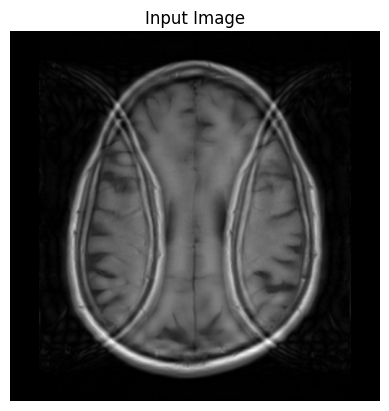

In [12]:
# Prepare data for model (same as test_part_listfm_vision_pretraining)
input_img = _data[DataKey.Input].unsqueeze(0).to(device)  # Add batch dim
text = _data[DataKey.Text].unsqueeze(0).to(device)
label = _data[DataKey.Label].unsqueeze(0).to(device)
instruction = _data[DataKey.Instruction].unsqueeze(0).to(device)

if TEXT_ENCODER_MODE == "llm":
    instruction_llm_ids = _data[DataKey.InstructionLLMIds].unsqueeze(0).to(device)
    instruction_llm_mask = _data[DataKey.InstructionLLMAttention].unsqueeze(0).to(device)
else:
    instruction_llm_ids = None
    instruction_llm_mask = _data[DataKey.InstructionLLMAttention].unsqueeze(0).to(device)

print(f"Input shape: {input_img.shape}")
print(f"Text shape: {text.shape}")
print(f"Instruction shape: {instruction.shape}")
if instruction_llm_ids is not None:
    print(f"Instruction LLM IDs shape: {instruction_llm_ids.shape}")
    print(f"Instruction LLM Mask shape: {instruction_llm_mask.shape}")
plt.imshow(input_img[0, 0].cpu().numpy(), cmap="gray")
plt.title("Input Image")
plt.axis("off")
plt.show()

In [13]:
# Run inference (same as test_part)
with torch.no_grad():
    output = rectified_flow_sample(
        model=model,
        img=input_img,
        text=text,
        instruction=instruction,
        instruction_llm_ids=instruction_llm_ids,
        instruction_llm_mask=instruction_llm_mask,
    )

print(f"Output shape: {output.shape}")

Output shape: torch.Size([1, 1, 512, 512])


Custom instruction: Change this T1 image to a T2.


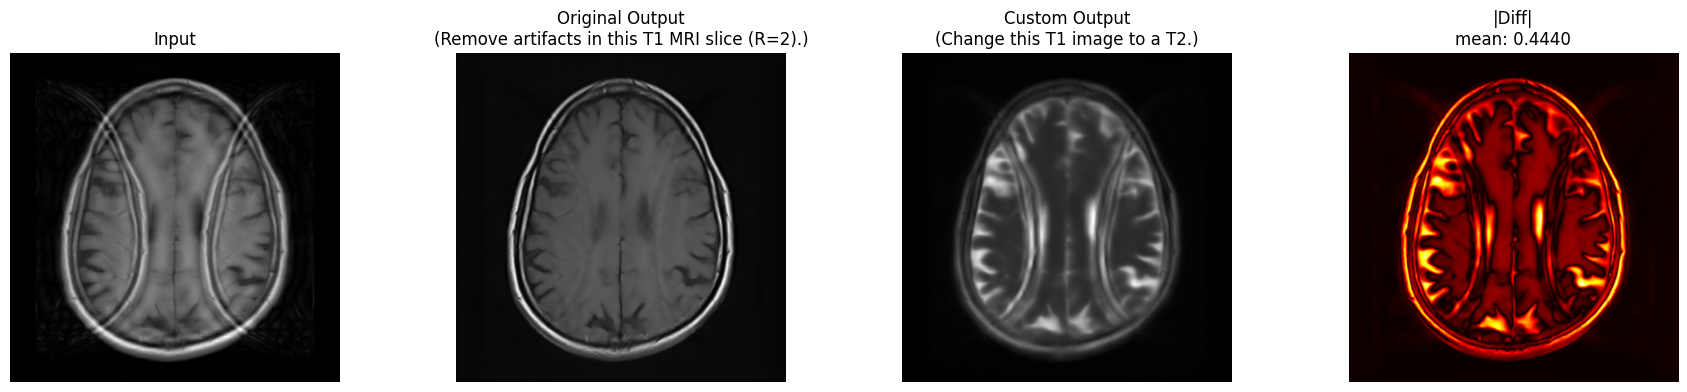


Metrics comparison:
Original - PSNR: 27.19, SSIM: 0.7631
Custom   - PSNR: 14.85, SSIM: 0.3402

Difference stats:
  Mean: 0.443955
  Max: 4.945274
  Std: 0.692876


In [18]:
# Custom Instruction Test: Manually specify instruction text
# Change the instruction to anything you want!

custom_instruction = "Change this T1 image to a T2."
# custom_instruction = "Reconstruct this T1 image. (R=4)"
# custom_instruction = "Enhance the contrast of this MRI image."
# custom_instruction = "Remove artifacts from this image."
# custom_instruction = "Convert this to a high-resolution image."

print(f"Custom instruction: {custom_instruction}")

# Tokenize the custom instruction using dataset's tokenizer
from datawrapper.simple_tokenizer import SimpleTokenizer
tokenizer_simple = SimpleTokenizer()

custom_instruction_token = tokenizer_simple.tokenize(custom_instruction, context_length=64).squeeze()

if TEXT_ENCODER_MODE == "llm":
    # Use the same tokenizer as dataset
    llm_inputs = dataset.qwen_tokenizer(
        custom_instruction,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt",
    )
    custom_llm_ids = llm_inputs["input_ids"].squeeze(0).to(device).unsqueeze(0)
    custom_llm_mask = llm_inputs["attention_mask"].squeeze(0).to(device).unsqueeze(0)
else:
    custom_llm_ids = None
    custom_llm_mask = (custom_instruction_token != 0).to(torch.long).to(device).unsqueeze(0)

# Run inference with custom instruction on the same input
with torch.no_grad():
    output_custom = rectified_flow_sample(
        model=model,
        img=input_img,
        text=text,
        # instruction=custom_instruction_token.to(device).unsqueeze(0),
        instruction=instruction,
        instruction_llm_ids=custom_llm_ids,
        instruction_llm_mask=custom_llm_mask,
        # instruction_llm_ids=instruction_llm_ids,
        # instruction_llm_mask=instruction_llm_mask,
    )

# Compare with original output
diff_custom = (output - output_custom).abs()

# Visualize
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
axes[0].imshow(input_img[0, 0].cpu().numpy(), cmap="gray")
axes[0].set_title("Input")
axes[0].axis("off")

axes[1].imshow(output[0, 0].cpu().numpy(), cmap="gray")
axes[1].set_title(f"Original Output\n({_data[DataKey.InstructionRaw]})")
axes[1].axis("off")

axes[2].imshow(output_custom[0, 0].cpu().numpy(), cmap="gray")
axes[2].set_title(f"Custom Output\n({custom_instruction})")
axes[2].axis("off")

axes[3].imshow(diff_custom[0, 0].cpu().numpy(), cmap="hot")
axes[3].set_title(f"|Diff|\nmean: {diff_custom.mean().item():.4f}")
axes[3].axis("off")

plt.tight_layout()
plt.show()

# Metrics
psnr_orig = calculate_psnr(output, label)
ssim_orig = calculate_ssim(output, label)
psnr_custom = calculate_psnr(output_custom, label)
ssim_custom = calculate_ssim(output_custom, label)

print(f"\nMetrics comparison:")
print(f"Original - PSNR: {psnr_orig.item():.2f}, SSIM: {ssim_orig.item():.4f}")
print(f"Custom   - PSNR: {psnr_custom.item():.2f}, SSIM: {ssim_custom.item():.4f}")
print(f"\nDifference stats:")
print(f"  Mean: {diff_custom.mean().item():.6f}")
print(f"  Max: {diff_custom.max().item():.6f}")
print(f"  Std: {diff_custom.std().item():.6f}")

In [28]:
# Calculate metrics
psnr = calculate_psnr(output, label)
ssim = calculate_ssim(output, label)
mse = torch.mean((output - label) ** 2)

print(f"PSNR: {psnr.item():.2f}")
print(f"SSIM: {ssim.item():.4f}")
print(f"MSE: {mse.item():.6f}")

PSNR: 34.29
SSIM: 0.8396
MSE: 0.006099


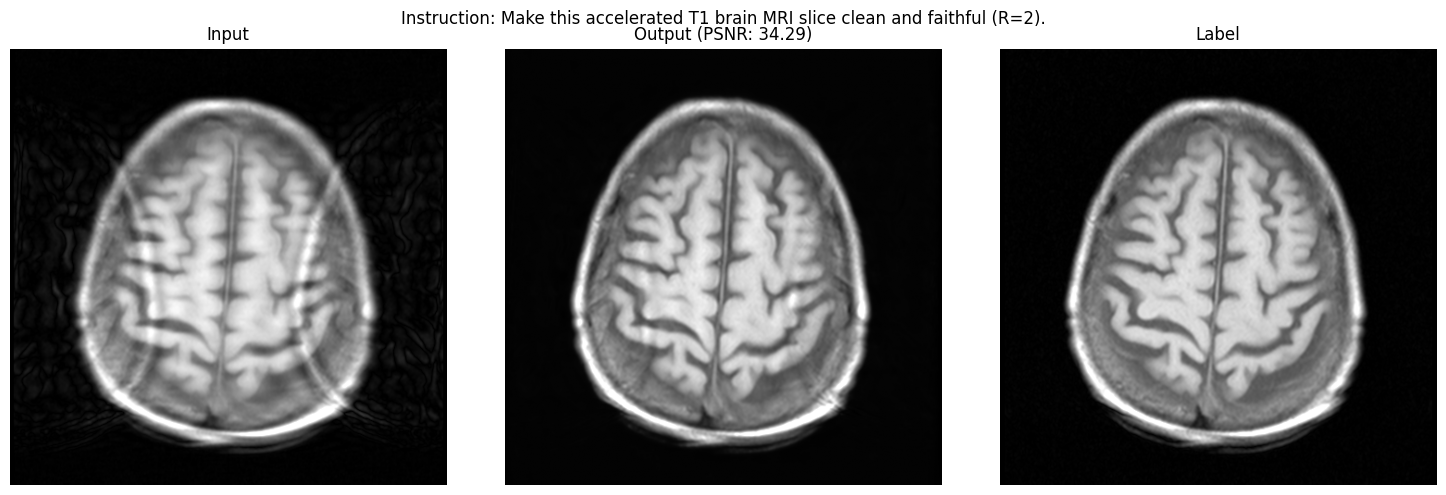

In [29]:
# Visualize results
input_vis = input_img.squeeze().detach().cpu().numpy()
output_vis = output.squeeze().detach().cpu().numpy()
label_vis = label.squeeze().detach().cpu().numpy()

x1, x2, y1, y2 = 20, -20, 20, -20

vmin_input = np.percentile(input_vis, 0.5)
vmax_input = np.percentile(input_vis, 99.5)
vmin_out = np.percentile(label_vis, 0.5)
vmax_out = np.percentile(label_vis, 99.5)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(input_vis[x1:x2, y1:y2], cmap="gray", vmin=vmin_input, vmax=vmax_input)
plt.title("Input")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(output_vis[x1:x2, y1:y2], cmap="gray", vmin=vmin_out, vmax=vmax_out)
plt.title(f"Output (PSNR: {psnr.item():.2f})")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(label_vis[x1:x2, y1:y2], cmap="gray", vmin=vmin_out, vmax=vmax_out)
plt.title("Label")
plt.axis("off")

plt.suptitle(f"Instruction: {_data[DataKey.InstructionRaw]}")
plt.tight_layout()
plt.show()

Sample A: Reduce aliasing artifacts in this T1 brain MRI image (R=8).
Sample B: Restore details in this T1 MRI scan (R=6).


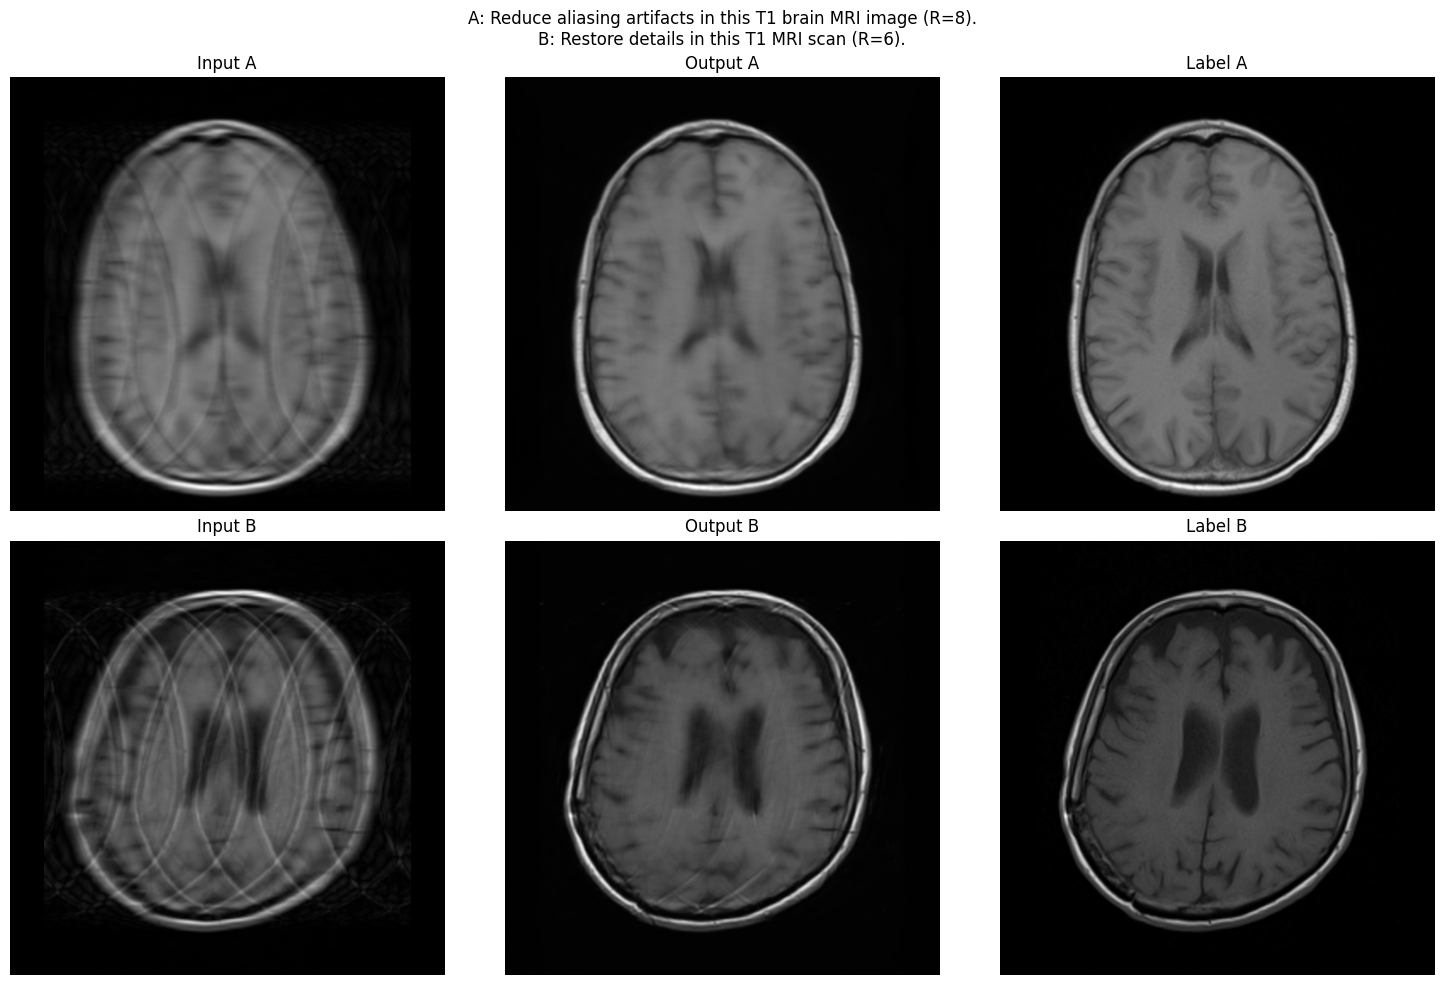


Metrics:
A - PSNR: 33.16, SSIM: 0.8297
B - PSNR: 34.24, SSIM: 0.7179


In [30]:
# A/B Test: Compare two different samples with different instructions
idx_a = random.randint(0, len(dataset) - 1)
idx_b = random.randint(0, len(dataset) - 1)

# Get data for both samples
data_a = dataset[idx_a]
data_b = dataset[idx_b]

_data_a = {
    DataKey.Input: data_a[0].unsqueeze(0).to(device),
    DataKey.Label: data_a[1].unsqueeze(0).to(device),
    DataKey.Text: data_a[2].unsqueeze(0).to(device),
    DataKey.Instruction: data_a[3].unsqueeze(0).to(device),
    DataKey.InstructionLLMIds: data_a[4].unsqueeze(0).to(device) if TEXT_ENCODER_MODE == "llm" else None,
    DataKey.InstructionLLMAttention: data_a[5].unsqueeze(0).to(device),
    DataKey.InstructionRaw: data_a[6],
}

_data_b = {
    DataKey.Input: data_b[0].unsqueeze(0).to(device),
    DataKey.Label: data_b[1].unsqueeze(0).to(device),
    DataKey.Text: data_b[2].unsqueeze(0).to(device),
    DataKey.Instruction: data_b[3].unsqueeze(0).to(device),
    DataKey.InstructionLLMIds: data_b[4].unsqueeze(0).to(device) if TEXT_ENCODER_MODE == "llm" else None,
    DataKey.InstructionLLMAttention: data_b[5].unsqueeze(0).to(device),
    DataKey.InstructionRaw: data_b[6],
}

print(f"Sample A: {_data_a[DataKey.InstructionRaw]}")
print(f"Sample B: {_data_b[DataKey.InstructionRaw]}")

# Run inference on both
with torch.no_grad():
    out_a = rectified_flow_sample(
        model=model,
        img=_data_a[DataKey.Input],
        text=_data_a[DataKey.Text],
        instruction=_data_a[DataKey.Instruction],
        instruction_llm_ids=_data_a[DataKey.InstructionLLMIds],
        instruction_llm_mask=_data_a[DataKey.InstructionLLMAttention],
    )
    
    out_b = rectified_flow_sample(
        model=model,
        img=_data_b[DataKey.Input],
        text=_data_b[DataKey.Text],
        instruction=_data_b[DataKey.Instruction],
        instruction_llm_ids=_data_b[DataKey.InstructionLLMIds],
        instruction_llm_mask=_data_b[DataKey.InstructionLLMAttention],
    )

# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row A
axes[0, 0].imshow(_data_a[DataKey.Input][0, 0].cpu().numpy(), cmap="gray")
axes[0, 0].set_title("Input A")
axes[0, 0].axis("off")

axes[0, 1].imshow(out_a[0, 0].cpu().numpy(), cmap="gray")
axes[0, 1].set_title("Output A")
axes[0, 1].axis("off")

axes[0, 2].imshow(_data_a[DataKey.Label][0, 0].cpu().numpy(), cmap="gray")
axes[0, 2].set_title("Label A")
axes[0, 2].axis("off")

# Row B
axes[1, 0].imshow(_data_b[DataKey.Input][0, 0].cpu().numpy(), cmap="gray")
axes[1, 0].set_title("Input B")
axes[1, 0].axis("off")

axes[1, 1].imshow(out_b[0, 0].cpu().numpy(), cmap="gray")
axes[1, 1].set_title("Output B")
axes[1, 1].axis("off")

axes[1, 2].imshow(_data_b[DataKey.Label][0, 0].cpu().numpy(), cmap="gray")
axes[1, 2].set_title("Label B")
axes[1, 2].axis("off")

plt.suptitle(f"A: {_data_a[DataKey.InstructionRaw]}\nB: {_data_b[DataKey.InstructionRaw]}")
plt.tight_layout()
plt.show()

# Metrics
psnr_a = calculate_psnr(out_a, _data_a[DataKey.Label])
ssim_a = calculate_ssim(out_a, _data_a[DataKey.Label])
psnr_b = calculate_psnr(out_b, _data_b[DataKey.Label])
ssim_b = calculate_ssim(out_b, _data_b[DataKey.Label])

print(f"\nMetrics:")
print(f"A - PSNR: {psnr_a.item():.2f}, SSIM: {ssim_a.item():.4f}")
print(f"B - PSNR: {psnr_b.item():.2f}, SSIM: {ssim_b.item():.4f}")

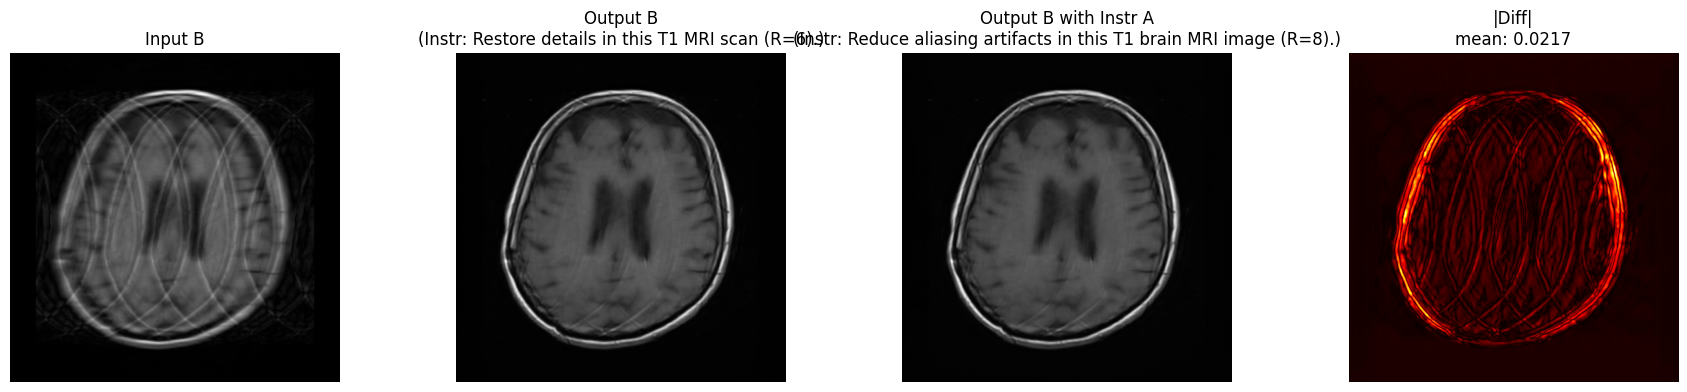

Difference stats:
  Mean: 0.021712
  Max: 0.389922
  Std: 0.031935


In [32]:
# Diagnostic: Check instruction encoding features
if TEXT_ENCODER_MODE == "llm":
    with torch.no_grad():
        _, feat_a = model.qwen_instruction_encoder(
            input_ids=_data_a[DataKey.InstructionLLMIds],
            attention_mask=_data_a[DataKey.InstructionLLMAttention],
        )
        _, feat_b = model.qwen_instruction_encoder(
            input_ids=_data_b[DataKey.InstructionLLMIds],
            attention_mask=_data_b[DataKey.InstructionLLMAttention],
        )
    
    # Feature comparison
    if feat_a.dim() == 3:  # [batch, seq, hidden]
        # Pool over sequence dimension with masking
        mask_a = _data_a[DataKey.InstructionLLMAttention].unsqueeze(-1)
        mask_b = _data_b[DataKey.InstructionLLMAttention].unsqueeze(-1)
        feat_a_pooled = (feat_a * mask_a).sum(dim=1) / mask_a.sum(dim=1).clamp(min=1)
        feat_b_pooled = (feat_b * mask_b).sum(dim=1) / mask_b.sum(dim=1).clamp(min=1)
    else:
        feat_a_pooled = feat_a
        feat_b_pooled = feat_b
    
    feat_diff = (feat_a_pooled - feat_b_pooled).abs().mean().item()
    feat_cos = torch.nn.functional.cosine_similarity(
        feat_a_pooled, feat_b_pooled, dim=1
    ).mean().item()
    
    print(f"\nInstruction feature analysis:")
    print(f"  Instruction A: {_data_a[DataKey.InstructionRaw]}")
    print(f"  Instruction B: {_data_b[DataKey.InstructionRaw]}")
    print(f"  Feature L1 diff: {feat_diff:.6f}")
    print(f"  Feature cosine sim: {feat_cos:.6f}")
    print(f"  Feature norm A: {feat_a_pooled.norm().item():.6f}")
    print(f"  Feature norm B: {feat_b_pooled.norm().item():.6f}")

Custom instruction: Change it to T2 modality after the reconstruction


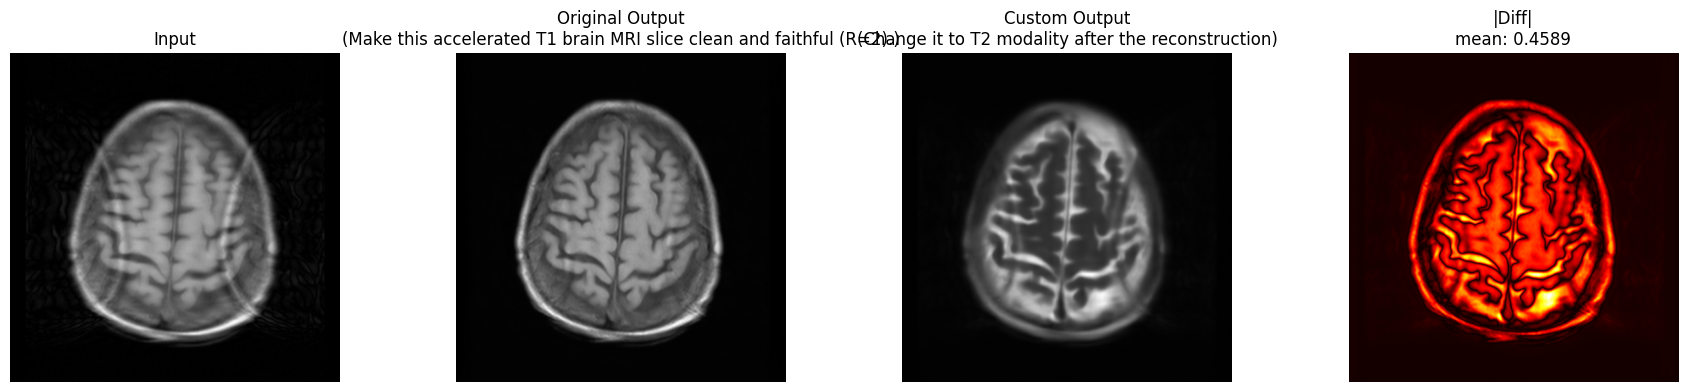


Metrics comparison:
Original - PSNR: 34.29, SSIM: 0.8396
Custom   - PSNR: 14.32, SSIM: 0.3719

Difference stats:
  Mean: 0.458863
  Max: 4.052147
  Std: 0.648531
